In [1]:
import pandas as pd
import numpy as np
import glob
import os
from pathlib import Path
import requests
import json

response = requests.get("https://floodzilla.com/api/client/APIGetLocationInfo?regionId=1")
gauges = response.json()
gauges_df = pd.DataFrame(gauges)
gauges_df['riverMile'] = gauges_df['id'].str.extract(r'([0-9]+)', expand=True).astype(int)

carn = next(g for g in gauges if g['id'] == "USGS-22")
floods_df = pd.DataFrame(carn['floodEvents'])
floods_df

,id,eventName,fromDate,toDate
0,30,2022 - March,2022-02-28T00:00:00,2022-03-06T00:00:00
1,29,2022 - January 21st,2022-01-20T00:00:00,2022-01-22T00:00:00
2,28,2022 - January 13th,2022-01-11T00:00:00,2022-01-15T00:00:00
3,26,2022 - January 7th,2022-01-06T00:00:00,2022-01-09T00:00:00
4,25,2021 - November,2021-11-11T00:00:00,2021-11-18T00:00:00
5,24,2021 - October,2021-10-28T00:00:00,2021-10-31T00:00:00
6,34,2021 - February,2021-02-21T00:00:00,2021-02-25T00:00:00
7,23,2021 - January,2021-01-12T00:00:00,2021-01-15T00:00:00
8,22,2020 - February 7th,2020-02-04T00:00:00,2020-02-13T00:00:00
9,20,2020 - February 1st,2020-01-31T00:00:00,2020-02-05T00:00:00


In [23]:
with open('../data_files//historic-crest-overrides.json') as f:
   overrides = json.load(f)

crests=[]
for fi,flood in floods_df.iterrows():
    for index,gauge in gauges_df.iterrows():
        if gauge['id'] in overrides and flood['eventName'] in overrides[gauge['id']]['overrides']:
            print("skipped", gauge['id'], flood['eventName'])
            continue
        url = 'https://prodplanreadingsvc.azurewebsites.net/api/GetGageReadingsUTC?regionId=1&id={}&fromDateTime={}&toDateTime={}&getMinimalReadings=true&includeStatus=true&includePredictions=true'.format(gauge['id'],flood['fromDate'],flood['toDate'])
        resp = requests.get(url).json()
        readings_df = pd.DataFrame(resp['readings'])
        if len(readings_df) == 0:
            continue
        readings_df['timestamp'] = pd.to_datetime(readings_df['timestamp'])
        readings_df.sort_values(by="timestamp", inplace=True)
        crest_height = np.max(readings_df['waterHeight'])

        peaks = readings_df[readings_df['waterHeight'] == crest_height ]
        peak_rec = peaks.iloc[0]
        peak_df = pd.DataFrame([peak_rec])
        peak_df['flood'] = flood['eventName']
        peak_df['gaugeId'] = gauge['id']
        peak_df['gaugeName'] = gauge['shortName']
        peak_df['riverMile'] = gauge['riverMile']

        # 0.1 ft before crest
        pre_peaks_level = np.max(readings_df[(readings_df['timestamp']<peak_rec['timestamp']) & (readings_df['waterHeight']<=(peak_rec['waterHeight'] - 0.1))]['waterHeight'])
        pre_peaks = readings_df[readings_df['waterHeight'] == pre_peaks_level]
        if len(pre_peaks):
            pre_peak_red = pre_peaks.iloc[0]
            if peak_rec['timestamp'] - pre_peak_red['timestamp'] <= np.timedelta64(4,'h') and peak_rec['waterHeight'] - pre_peak_red['waterHeight'] <= 0.5:
                peak_df['prePeakWaterHeight'] = pre_peak_red['waterHeight']
                peak_df['prePeakTimestamp'] = pre_peak_red['timestamp']

        peak_df.drop(columns=['isDeleted', 'isMissing'], inplace=True)
        
        crests.append(peak_df)
        

crests_df = pd.concat(crests)
crests_df.head()

skipped SVPA-34 2022 - January 21st
skipped SVPA-37 2022 - January 7th
skipped SVPA-37 2021 - January
skipped SVPA-34 2021 - January
skipped SVPA-26 2021 - January
skipped SVPA-26 2020 - February 7th
skipped SVPA-17 2020 - February 7th
skipped SVPA-26 2020 - February 1st
skipped SVPA-17 2020 - February 1st
skipped SVPA-34 2019 - December
skipped SVPA-26 2019 - October


,id,timestamp,waterHeight,waterDischarge,flood,gaugeId,gaugeName,riverMile,prePeakWaterHeight,prePeakTimestamp
442,1392798,2022-03-01 01:15:00,15.76,4550.0,2022 - March,USGS-SF17,South Fork,17,15.64,2022-03-01 00:30:00
442,1392793,2022-03-01 01:15:00,12.03,18500.0,2022 - March,USGS-MF11,Middle Fork,11,11.93,2022-03-01 00:15:00
446,1392686,2022-02-28 23:30:00,10.70,10500.0,2022 - March,USGS-NF10,North Fork,10,10.58,2022-02-28 23:15:00
413,1393252,2022-03-01 08:00:00,16.91,38500.0,2022 - March,USGS-38,Below the Falls,38,16.80,2022-03-01 07:45:00
388,1393330,2022-03-01 09:15:06,94.47,NaN,2022 - March,SVPA-37,Sno Falls Golf,37,94.37,2022-03-01 07:15:06


In [50]:
# overrides
with open('../data_files//historic-crest-overrides.json') as f:
   overrides = json.load(f)
for gauge_id in overrides:
   for flood in overrides[gauge_id]['overrides']:
      crests_df.drop(crests_df[(crests_df['gaugeId'] == gauge_id) & (crests_df['flood'] == flood)].index, inplace=True)

      

In [24]:

crests_df['prePeakGap'] = (crests_df['timestamp'] - crests_df['prePeakTimestamp'] )/ np.timedelta64(1, 'm')
crests_df[crests_df['gaugeId']=='USGS-22']

,id,timestamp,waterHeight,waterDischarge,flood,gaugeId,gaugeName,riverMile,prePeakWaterHeight,prePeakTimestamp,prePeakGap
379,1393860,2022-03-01 17:00:00,58.73,46800.00,2022 - March,USGS-22,Carnation,22,58.62,2022-03-01 15:15:00,105.0
44,1332391,2022-01-21 04:45:00,53.37,19800.00,2022 - January 21st,USGS-22,Carnation,22,53.26,2022-01-21 02:15:00,150.0
151,1319648,2022-01-13 02:00:00,56.93,28400.00,2022 - January 13th,USGS-22,Carnation,22,56.83,2022-01-13 00:00:00,120.0
67,1311662,2022-01-07 23:00:00,54.00,21200.00,2022 - January 7th,USGS-22,Carnation,22,53.89,2022-01-07 20:30:00,150.0
422,1224847,2021-11-13 05:30:00,57.12,28900.00,2021 - November,USGS-22,Carnation,22,56.99,2021-11-13 03:45:00,105.0
101,1198498,2021-10-29 15:30:00,55.26,24300.00,2021 - October,USGS-22,Carnation,22,55.16,2021-10-29 13:45:00,105.0
148,828202,2021-02-23 02:45:00,53.03,18800.00,2021 - February,USGS-22,Carnation,22,52.93,2021-02-23 00:30:00,135.0
86,764823,2021-01-13 18:15:00,55.33,24600.00,2021 - January,USGS-22,Carnation,22,55.22,2021-01-13 16:30:00,105.0
467,220605,2020-02-07 19:00:00,58.50,42300.00,2020 - February 7th,USGS-22,Carnation,22,58.40,2020-02-07 15:00:00,240.0
255,212054,2020-02-02 00:00:00,58.42,40600.00,2020 - February 1st,USGS-22,Carnation,22,58.32,2020-02-01 21:45:00,135.0


In [25]:
import plotly.express as px
fig = px.histogram(crests_df, x="prePeakGap")
fig.show()

In [26]:
falls_floods = pd.DataFrame(crests_df[crests_df['gaugeId']=='USGS-38'][['flood','timestamp']])
falls_floods['fallsCrestTimestamp'] = falls_floods['timestamp']
falls_floods=falls_floods[['flood','fallsCrestTimestamp']]

crests_df= pd.merge(crests_df, falls_floods, on='flood',)

crests_df

,id,timestamp,waterHeight,waterDischarge,flood,gaugeId,gaugeName,riverMile,prePeakWaterHeight,prePeakTimestamp,prePeakGap,fallsCrestTimestamp
0,1392798,2022-03-01 01:15:00,15.76,4550.0,2022 - March,USGS-SF17,South Fork,17,15.64,2022-03-01 00:30:00,45.0,2022-03-01 08:00:00
1,1392793,2022-03-01 01:15:00,12.03,18500.0,2022 - March,USGS-MF11,Middle Fork,11,11.93,2022-03-01 00:15:00,60.0,2022-03-01 08:00:00
2,1392686,2022-02-28 23:30:00,10.70,10500.0,2022 - March,USGS-NF10,North Fork,10,10.58,2022-02-28 23:15:00,15.0,2022-03-01 08:00:00
3,1393252,2022-03-01 08:00:00,16.91,38500.0,2022 - March,USGS-38,Below the Falls,38,16.80,2022-03-01 07:45:00,15.0,2022-03-01 08:00:00
4,1393330,2022-03-01 09:15:06,94.47,NaN,2022 - March,SVPA-37,Sno Falls Golf,37,94.37,2022-03-01 07:15:06,120.0,2022-03-01 08:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...
187,50292,2019-10-23 06:00:05,53.81,NaN,2019 - October,SVPA-17,NE 100th St,17,53.71,2019-10-23 04:30:05,90.0,2019-10-22 08:50:00
188,50553,2019-10-23 08:45:03,46.96,NaN,2019 - October,SVPA-15,NE 124th St (E),15,46.84,2019-10-23 07:00:03,105.0,2019-10-22 08:50:00
189,50522,2019-10-23 08:30:01,45.26,NaN,2019 - October,SVPA-12,NE 138th St,12,45.16,2019-10-23 06:30:01,120.0,2019-10-22 08:50:00
190,50633,2019-10-23 09:30:00,40.53,NaN,2019 - October,USGS-9,Duvall,9,40.43,2019-10-23 06:00:00,210.0,2019-10-22 08:50:00


In [27]:
crests_df['crestAfterFalls'] = (crests_df['timestamp'] - crests_df['fallsCrestTimestamp']) / np.timedelta64(1,'h')
crests_df[crests_df['gaugeId']=='USGS-22']

,id,timestamp,waterHeight,waterDischarge,flood,gaugeId,gaugeName,riverMile,prePeakWaterHeight,prePeakTimestamp,prePeakGap,fallsCrestTimestamp,crestAfterFalls
10,1393860,2022-03-01 17:00:00,58.73,46800.00,2022 - March,USGS-22,Carnation,22,58.62,2022-03-01 15:15:00,105.0,2022-03-01 08:00:00,9.000000
26,1332391,2022-01-21 04:45:00,53.37,19800.00,2022 - January 21st,USGS-22,Carnation,22,53.26,2022-01-21 02:15:00,150.0,2022-01-20 21:15:00,7.500000
43,1319648,2022-01-13 02:00:00,56.93,28400.00,2022 - January 13th,USGS-22,Carnation,22,56.83,2022-01-13 00:00:00,120.0,2022-01-12 13:30:00,12.500000
59,1311662,2022-01-07 23:00:00,54.00,21200.00,2022 - January 7th,USGS-22,Carnation,22,53.89,2022-01-07 20:30:00,150.0,2022-01-07 17:15:00,5.750000
76,1224847,2021-11-13 05:30:00,57.12,28900.00,2021 - November,USGS-22,Carnation,22,56.99,2021-11-13 03:45:00,105.0,2021-11-12 19:00:00,10.500000
93,1198498,2021-10-29 15:30:00,55.26,24300.00,2021 - October,USGS-22,Carnation,22,55.16,2021-10-29 13:45:00,105.0,2021-10-29 02:45:00,12.750000
109,828202,2021-02-23 02:45:00,53.03,18800.00,2021 - February,USGS-22,Carnation,22,52.93,2021-02-23 00:30:00,135.0,2021-02-22 19:15:00,7.500000
122,764823,2021-01-13 18:15:00,55.33,24600.00,2021 - January,USGS-22,Carnation,22,55.22,2021-01-13 16:30:00,105.0,2021-01-13 08:00:00,10.250000
136,220605,2020-02-07 19:00:00,58.50,42300.00,2020 - February 7th,USGS-22,Carnation,22,58.40,2020-02-07 15:00:00,240.0,2020-02-07 10:20:00,8.666667
148,212054,2020-02-02 00:00:00,58.42,40600.00,2020 - February 1st,USGS-22,Carnation,22,58.32,2020-02-01 21:45:00,135.0,2020-02-01 15:00:00,9.000000


In [54]:
# crests_df[['crestAfterFalls']]
import plotly.express as px
fig = px.scatter(crests_df[crests_df['gaugeId'].str.startswith("SVPA") & (crests_df['riverMile']>=22)], x="crestAfterFalls", y="waterHeight", color='gaugeId', hover_data=['flood','gaugeName'])
fig.show()

In [60]:
crests_df[crests_df['gaugeId'].str.startswith("SVPA")][['gaugeId','gaugeName','crestAfterFalls']].groupby(['gaugeId']).var().reset_index()

,gaugeId,crestAfterFalls
0,SVPA-12,228.830220
1,SVPA-15,199.767443
2,SVPA-15B,366.416807
3,SVPA-17,241.229692
4,SVPA-25,8.597696
5,SVPA-26,6.312261
6,SVPA-33,0.696954
7,SVPA-34,0.557433
8,SVPA-36,0.373973
9,SVPA-37,0.362039


In [62]:
falls_floods = pd.DataFrame(crests_df[crests_df['gaugeId']=='USGS-38'][['flood','prePeakTimestamp']])
falls_floods['fallsPrePeakTimestamp'] = falls_floods['prePeakTimestamp']
falls_floods=falls_floods[['flood','fallsPrePeakTimestamp']]

crests_df= pd.merge(crests_df, falls_floods, on='flood',)

crests_df

,id,timestamp,waterHeight,waterDischarge,flood,gaugeId,gaugeName,riverMile,prePeakWaterHeight,prePeakTimestamp,prePeakGap,fallsCrestTimestamp,crestAfterFalls,fallsPrePeakTimestamp
0,1392798,2022-03-01 01:15:00,15.76,4550.0,2022 - March,USGS-SF17,South Fork,17,15.64,2022-03-01 00:30:00,45.0,2022-03-01 08:00:00,-6.750000,2022-03-01 07:45:00
1,1392793,2022-03-01 01:15:00,12.03,18500.0,2022 - March,USGS-MF11,Middle Fork,11,11.93,2022-03-01 00:15:00,60.0,2022-03-01 08:00:00,-6.750000,2022-03-01 07:45:00
2,1392686,2022-02-28 23:30:00,10.70,10500.0,2022 - March,USGS-NF10,North Fork,10,10.58,2022-02-28 23:15:00,15.0,2022-03-01 08:00:00,-8.500000,2022-03-01 07:45:00
3,1393252,2022-03-01 08:00:00,16.91,38500.0,2022 - March,USGS-38,Below the Falls,38,16.80,2022-03-01 07:45:00,15.0,2022-03-01 08:00:00,0.000000,2022-03-01 07:45:00
4,1393330,2022-03-01 09:15:06,94.47,NaN,2022 - March,SVPA-37,Sno Falls Golf,37,94.37,2022-03-01 07:15:06,120.0,2022-03-01 08:00:00,1.251667,2022-03-01 07:45:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184,50292,2019-10-23 06:00:05,53.81,NaN,2019 - October,SVPA-17,NE 100th St,17,53.71,2019-10-23 04:30:05,90.0,2019-10-22 08:50:00,21.168056,2019-10-22 08:45:00
185,50553,2019-10-23 08:45:03,46.96,NaN,2019 - October,SVPA-15,NE 124th St (E),15,46.84,2019-10-23 07:00:03,105.0,2019-10-22 08:50:00,23.917500,2019-10-22 08:45:00
186,50522,2019-10-23 08:30:01,45.26,NaN,2019 - October,SVPA-12,NE 138th St,12,45.16,2019-10-23 06:30:01,120.0,2019-10-22 08:50:00,23.666944,2019-10-22 08:45:00
187,50633,2019-10-23 09:30:00,40.53,NaN,2019 - October,USGS-9,Duvall,9,40.43,2019-10-23 06:00:00,210.0,2019-10-22 08:50:00,24.666667,2019-10-22 08:45:00


In [63]:
crests_df['crestAfterFallsPre'] = (crests_df['timestamp'] - crests_df['fallsPrePeakTimestamp']) / np.timedelta64(1,'h')
crests_df[crests_df['gaugeId']=='USGS-22']

,id,timestamp,waterHeight,waterDischarge,flood,gaugeId,gaugeName,riverMile,prePeakWaterHeight,prePeakTimestamp,prePeakGap,fallsCrestTimestamp,crestAfterFalls,fallsPrePeakTimestamp,crestAfterFallsPre
10,1393860,2022-03-01 17:00:00,58.73,46800.00,2022 - March,USGS-22,Carnation,22,58.62,2022-03-01 15:15:00,105.0,2022-03-01 08:00:00,9.000000,2022-03-01 07:45:00,9.250000
26,1332391,2022-01-21 04:45:00,53.37,19800.00,2022 - January 21st,USGS-22,Carnation,22,53.26,2022-01-21 02:15:00,150.0,2022-01-20 21:15:00,7.500000,2022-01-20 20:30:00,8.250000
43,1319648,2022-01-13 02:00:00,56.93,28400.00,2022 - January 13th,USGS-22,Carnation,22,56.83,2022-01-13 00:00:00,120.0,2022-01-12 13:30:00,12.500000,2022-01-12 13:15:00,12.750000
59,1311662,2022-01-07 23:00:00,54.00,21200.00,2022 - January 7th,USGS-22,Carnation,22,53.89,2022-01-07 20:30:00,150.0,2022-01-07 17:15:00,5.750000,2022-01-07 15:45:00,7.250000
76,1224847,2021-11-13 05:30:00,57.12,28900.00,2021 - November,USGS-22,Carnation,22,56.99,2021-11-13 03:45:00,105.0,2021-11-12 19:00:00,10.500000,2021-11-12 17:45:00,11.750000
93,1198498,2021-10-29 15:30:00,55.26,24300.00,2021 - October,USGS-22,Carnation,22,55.16,2021-10-29 13:45:00,105.0,2021-10-29 02:45:00,12.750000,2021-10-29 01:00:00,14.500000
109,828202,2021-02-23 02:45:00,53.03,18800.00,2021 - February,USGS-22,Carnation,22,52.93,2021-02-23 00:30:00,135.0,2021-02-22 19:15:00,7.500000,2021-02-22 18:15:00,8.500000
121,764823,2021-01-13 18:15:00,55.33,24600.00,2021 - January,USGS-22,Carnation,22,55.22,2021-01-13 16:30:00,105.0,2021-01-13 08:00:00,10.250000,2021-01-13 07:30:00,10.750000
134,220605,2020-02-07 19:00:00,58.50,42300.00,2020 - February 7th,USGS-22,Carnation,22,58.40,2020-02-07 15:00:00,240.0,2020-02-07 10:20:00,8.666667,2020-02-07 09:25:00,9.583333
146,212054,2020-02-02 00:00:00,58.42,40600.00,2020 - February 1st,USGS-22,Carnation,22,58.32,2020-02-01 21:45:00,135.0,2020-02-01 15:00:00,9.000000,2020-02-01 14:00:00,10.000000


In [64]:
# crests_df[['crestAfterFalls']]
import plotly.express as px
fig = px.scatter(crests_df[crests_df['gaugeId'].str.startswith("SVPA") & (crests_df['riverMile']>=22)], x="crestAfterFallsPre", y="waterHeight", color='gaugeId', hover_data=['flood','gaugeName'])
fig.show()

In [65]:
crests_df[crests_df['gaugeId'].str.startswith("SVPA")][['gaugeId','gaugeName','crestAfterFalls']].groupby(['gaugeId']).var().reset_index()

,gaugeId,crestAfterFalls
0,SVPA-12,228.830220
1,SVPA-15,199.767443
2,SVPA-15B,366.416807
3,SVPA-17,241.229692
4,SVPA-25,8.597696
5,SVPA-26,6.312261
6,SVPA-33,0.696954
7,SVPA-34,0.557433
8,SVPA-36,0.373973
9,SVPA-37,0.362039


In [66]:
crests_df[crests_df['gaugeId'].str.startswith("SVPA")][['gaugeId','gaugeName','crestAfterFallsPre']].groupby(['gaugeId']).var().reset_index()

,gaugeId,crestAfterFallsPre
0,SVPA-12,231.195431
1,SVPA-15,203.361901
2,SVPA-15B,370.707189
3,SVPA-17,245.597041
4,SVPA-25,8.287525
5,SVPA-26,6.977280
6,SVPA-33,1.125709
7,SVPA-34,0.879719
8,SVPA-36,0.384635
9,SVPA-37,0.500130


In [68]:
carn_floods = pd.DataFrame(crests_df[crests_df['gaugeId']=='USGS-22'][['flood','timestamp']])
carn_floods['carnCrestTimestamp'] = carn_floods['timestamp']
carn_floods=carn_floods[['flood','carnCrestTimestamp']]

crests_df= pd.merge(crests_df, carn_floods, on='flood',)

crests_df

,id,timestamp,waterHeight,waterDischarge,flood,gaugeId,gaugeName,riverMile,prePeakWaterHeight,prePeakTimestamp,prePeakGap,fallsCrestTimestamp,crestAfterFalls,fallsPrePeakTimestamp,crestAfterFallsPre,carnCrestTimestamp
0,1392798,2022-03-01 01:15:00,15.76,4550.0,2022 - March,USGS-SF17,South Fork,17,15.64,2022-03-01 00:30:00,45.0,2022-03-01 08:00:00,-6.750000,2022-03-01 07:45:00,-6.500000,2022-03-01 17:00:00
1,1392793,2022-03-01 01:15:00,12.03,18500.0,2022 - March,USGS-MF11,Middle Fork,11,11.93,2022-03-01 00:15:00,60.0,2022-03-01 08:00:00,-6.750000,2022-03-01 07:45:00,-6.500000,2022-03-01 17:00:00
2,1392686,2022-02-28 23:30:00,10.70,10500.0,2022 - March,USGS-NF10,North Fork,10,10.58,2022-02-28 23:15:00,15.0,2022-03-01 08:00:00,-8.500000,2022-03-01 07:45:00,-8.250000,2022-03-01 17:00:00
3,1393252,2022-03-01 08:00:00,16.91,38500.0,2022 - March,USGS-38,Below the Falls,38,16.80,2022-03-01 07:45:00,15.0,2022-03-01 08:00:00,0.000000,2022-03-01 07:45:00,0.250000,2022-03-01 17:00:00
4,1393330,2022-03-01 09:15:06,94.47,NaN,2022 - March,SVPA-37,Sno Falls Golf,37,94.37,2022-03-01 07:15:06,120.0,2022-03-01 08:00:00,1.251667,2022-03-01 07:45:00,1.501667,2022-03-01 17:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184,50292,2019-10-23 06:00:05,53.81,NaN,2019 - October,SVPA-17,NE 100th St,17,53.71,2019-10-23 04:30:05,90.0,2019-10-22 08:50:00,21.168056,2019-10-22 08:45:00,21.251389,2019-10-22 20:45:00
185,50553,2019-10-23 08:45:03,46.96,NaN,2019 - October,SVPA-15,NE 124th St (E),15,46.84,2019-10-23 07:00:03,105.0,2019-10-22 08:50:00,23.917500,2019-10-22 08:45:00,24.000833,2019-10-22 20:45:00
186,50522,2019-10-23 08:30:01,45.26,NaN,2019 - October,SVPA-12,NE 138th St,12,45.16,2019-10-23 06:30:01,120.0,2019-10-22 08:50:00,23.666944,2019-10-22 08:45:00,23.750278,2019-10-22 20:45:00
187,50633,2019-10-23 09:30:00,40.53,NaN,2019 - October,USGS-9,Duvall,9,40.43,2019-10-23 06:00:00,210.0,2019-10-22 08:50:00,24.666667,2019-10-22 08:45:00,24.750000,2019-10-22 20:45:00


In [69]:
crests_df['crestAfterCarn'] = (crests_df['timestamp'] - crests_df['carnCrestTimestamp']) / np.timedelta64(1,'h')
crests_df[crests_df['gaugeId']=='SVPA-15']

,id,timestamp,waterHeight,waterDischarge,flood,gaugeId,gaugeName,riverMile,prePeakWaterHeight,prePeakTimestamp,prePeakGap,fallsCrestTimestamp,crestAfterFalls,fallsPrePeakTimestamp,crestAfterFallsPre,carnCrestTimestamp,crestAfterCarn
12,1394291,2022-03-01 23:30:24,50.21,NaN,2022 - March,SVPA-15,NE 124th St (E),15,50.10,2022-03-01 21:30:07,120.283333,2022-03-01 08:00:00,15.506667,2022-03-01 07:45:00,15.756667,2022-03-01 17:00:00,6.506667
28,1333096,2022-01-21 15:45:04,41.44,NaN,2022 - January 21st,SVPA-15,NE 124th St (E),15,41.32,2022-01-21 14:00:04,105.000000,2022-01-20 21:15:00,18.501111,2022-01-20 20:30:00,19.251111,2022-01-21 04:45:00,11.001111
45,1320593,2022-01-13 16:30:04,46.28,NaN,2022 - January 13th,SVPA-15,NE 124th St (E),15,46.17,2022-01-13 13:00:04,210.000000,2022-01-12 13:30:00,27.001111,2022-01-12 13:15:00,27.251111,2022-01-13 02:00:00,14.501111
61,1312402,2022-01-08 10:45:11,43.36,NaN,2022 - January 7th,SVPA-15,NE 124th St (E),15,43.26,2022-01-08 08:45:11,120.000000,2022-01-07 17:15:00,17.503056,2022-01-07 15:45:00,19.003056,2022-01-07 23:00:00,11.753056
78,1229022,2021-11-15 16:44:56,47.11,NaN,2021 - November,SVPA-15,NE 124th St (E),15,46.99,2021-11-15 14:29:56,135.000000,2021-11-12 19:00:00,69.748889,2021-11-12 17:45:00,70.998889,2021-11-13 05:30:00,59.248889
95,1199611,2021-10-30 07:00:06,43.79,NaN,2021 - October,SVPA-15,NE 124th St (E),15,43.67,2021-10-30 05:00:06,120.000000,2021-10-29 02:45:00,28.251667,2021-10-29 01:00:00,30.001667,2021-10-29 15:30:00,15.501667
111,829300,2021-02-23 19:30:05,41.61,NaN,2021 - February,SVPA-15,NE 124th St (E),15,NaN,NaT,NaN,2021-02-22 19:15:00,24.251389,2021-02-22 18:15:00,25.251389,2021-02-23 02:45:00,16.751389
122,765437,2021-01-14 07:45:12,44.31,NaN,2021 - January,SVPA-15,NE 124th St (E),15,44.03,2021-01-14 03:45:12,240.000000,2021-01-13 08:00:00,23.753333,2021-01-13 07:30:00,24.253333,2021-01-13 18:15:00,13.503333
135,221212,2020-02-08 04:00:41,49.87,NaN,2020 - February 7th,SVPA-15,NE 124th St (E),15,NaN,NaT,NaN,2020-02-07 10:20:00,17.678056,2020-02-07 09:25:00,18.594722,2020-02-07 19:00:00,9.011389
147,212334,2020-02-02 04:30:00,49.86,NaN,2020 - February 1st,SVPA-15,NE 124th St (E),15,49.75,2020-02-02 02:29:59,120.016667,2020-02-01 15:00:00,13.500000,2020-02-01 14:00:00,14.500000,2020-02-02 00:00:00,4.500000


In [73]:
# crests_df[['crestAfterFalls']]
import plotly.express as px
fig = px.scatter(crests_df[crests_df['gaugeId'].str.startswith("SVPA") &
  (crests_df['flood']!="2021 - November") &
 (crests_df['riverMile']<22)], x="crestAfterCarn", y="waterHeight", color='gaugeId', hover_data=['flood','gaugeName'])
fig.show()

In [78]:
falls_means = crests_df[crests_df['gaugeId'].str.startswith("SVPA")][['gaugeId','gaugeName','crestAfterFalls']].groupby(['gaugeId']).mean().reset_index()
falls_means

,gaugeId,crestAfterFalls
0,SVPA-12,24.142991
1,SVPA-15,25.644444
2,SVPA-15B,23.532083
3,SVPA-17,24.793722
4,SVPA-25,6.812465
5,SVPA-26,7.873364
6,SVPA-33,2.861717
7,SVPA-34,4.134556
8,SVPA-36,2.249398
9,SVPA-37,0.992806


In [82]:
from sklearn import linear_model
def build_basic_model(x_gauge_id:str, predicted_hours:float):
    x_gauge_df = crests_df[crests_df['gaugeId']==x_gauge_id]
    X = np.array(x_gauge_df['crestAfterFalls']).reshape(-1,1)
    y = [predicted_hours] * len(X)
    regr = linear_model.LinearRegression()
    regr.fit(X,y)
    score = regr.score(X,y)
    print(regr.coef_, regr.intercept_)
    print(len(y), score)
    return regr, len(y), score, X, y

model,n,score,X,y = build_basic_model('SVPA-34', 4.134556)

[7.04389174e-31] 4.134556000000001
10 0.0


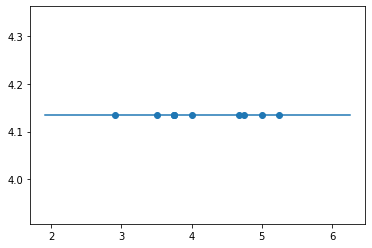

In [83]:
import matplotlib.pyplot as plt

def plot_model(model, X,y):
    xfit = np.linspace(np.min(X)-1, np.max(X)+1, 1000)
    yfit = model.predict(xfit[:, np.newaxis])

    # Plot the estimated linear regression line with matplotlib:
    plt.scatter(X, y)
    plt.plot(xfit, yfit);
    plt.show()

plot_model(model, X,y)